# Library

In [ ]:
import os 
from pickle import dump
from pickle import load
from os import listdir
import numpy as np
from os import getcwd
import string
import numpy as np
import tensorflow as tf
import keras.backend as K
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras_preprocessing.image import load_img
from keras_preprocessing.image import img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import History    
from keras.optimizers import Adam
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
import sys

In [ ]:
import re
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
from keras.layers import Concatenate

In [ ]:
from keras.layers import RepeatVector

In [ ]:
os.chdir("/content/drive/My Drive/Image Captioning/")

In [ ]:
getcwd()

'/content/drive/My Drive/Image Captioning'

# Text

In [ ]:
def load_doc(directory):
  file=open(directory,'r')
  text=file.read()
  file.close()
  return text

In [ ]:
dir='descriptions.txt'
train_dir='Flickr8k_text/Flickr_8k.trainImages.txt'

In [ ]:
text=load_doc(train_dir)

In [ ]:
def load_set(directory):
  text=load_doc(directory)
  data=list()

  for line in text.split('\n'):
    if len(line)<1:
      continue

    data.append(line.split('.')[0])

  return set(data)

In [ ]:
def load_clean_descriptions(directory,dataset):
  file=load_doc(directory)
  des=dict()
  for line in file.split('\n'):
    seq=line.split()
    image_id,image_des=seq[0],seq[1:]
    if image_id in dataset:
      if image_id not in des:
        des[image_id]=list()
        
      des[image_id].append('startseq ' + ' '.join(image_des) + ' endseq')

  return des 

In [ ]:
train_dir = load_set("Flickr8k_text/Flickr_8k.trainImages.txt")
print("Train Dataset Length:",len(train_dir))
test_dir = load_set("Flickr8k_text/Flickr_8k.testImages.txt")
print("Test Dataset Length:",len(test_dir))
dev_dir = load_set("Flickr8k_text/Flickr_8k.devImages.txt")
print("Test Dataset Length:",len(dev_dir))

train_descriptions = load_clean_descriptions(dir,train_dir)
test_descriptions = load_clean_descriptions(dir,test_dir)
dev_descriptions = load_clean_descriptions(dir,dev_dir)

Train Dataset Length: 6000
Test Dataset Length: 1000
Test Dataset Length: 1000


In [ ]:
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

In [ ]:
def to_vocabulary(description,word_count_threshold=5):
  all_captions=to_lines(description)

  word_count={}
  for line in all_captions:
    for word in line.split():
      word_count[word]=word_count.get(word,0)+1
    
  vocab=[w for w in word_count if word_count[w]>=word_count_threshold]
  return vocab

vocab=to_vocabulary(train_descriptions,5)
print("Size of Vocabulary Size : ", len(vocab))

Size of Vocabulary Size :  2530


In [ ]:
sorted(vocab)[:10]

['about',
 'above',
 'accordion',
 'acrobatic',
 'across',
 'act',
 'action',
 'adult',
 'adults',
 'advertisement']

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def create_tokenizer(vocab):
  tokenizer=Tokenizer(oov_token='UNK')
  tokenizer.fit_on_texts(vocab)
  return tokenizer

tokenizer=create_tokenizer(vocab)
vocab_size=len(tokenizer.word_index)+1
print('Vocab size ',vocab_size)


Vocab size  2532


In [ ]:
tokenizer.word_index['PAD0']=0

In [ ]:
wordtoix = {}
ixtoword = {}

#no word in vocab has index 0, but padding will have index 0
tokenizer.word_index['PAD0'] = 0 
wordtoix = tokenizer.word_index
for word in tokenizer.word_index:
  ixtoword[tokenizer.word_index[word]] = word

print(len(ixtoword), len(wordtoix))

2532 2532


In [ ]:
def max_length(description, p):
	#lines = to_lines(descriptions)
	#return max(len(d.split()) for d in lines)
  all_desc = []
  #create a list of all desc
  for key, desc in description.items():
    [all_desc.append(line) for line in desc]
  length = list(len(line.split()) for line in all_desc)
  print('{} percentile has len of lines less than: {}'.format(p,np.percentile(length, p)))
  print('longest sentence: ', max(length))
  return int(np.percentile(length, p))

 
max_length = max_length(train_descriptions,90)
print("Max Length for training:",max_length)

90 percentile has len of lines less than: 16.0
longest sentence:  34
Max Length for training: 16


# Image text

In [ ]:
from pickle import load

def load_photo_features(directory,dataset):
  all_features=load(open(directory,'rb'))
  features={k:all_features[k] for k in dataset}
  return features


In [ ]:
dir='features.pkl'
train_features = load_photo_features(dir, train_dir)
print('Photos:',len(train_features))
test_features = load_photo_features(dir,test_dir)
print('Photos:',len(test_features))
dev_features = load_photo_features(dir,dev_dir)
print('Photos:',len(dev_features))

Photos: 6000
Photos: 1000
Photos: 1000


# Model

In [ ]:
batch_size = 32
def data_generator(descriptions, photos):
  X1, X2, y = [], [], []
  n=0
  # loop for ever over images
  while 1:
    for key, desc_list in descriptions.items():
      n+=1
      # retrieve the photo feature
      photo = photos[key]
      for desc in desc_list:
        # find the index of each word of the caption in vocabulary
        seq = tokenizer.texts_to_sequences(desc.split())
        # split one sequence into multiple X, y pairs
        # Each step of the following for loop selects one word
        # from the caption, consider that word as y and
        # all the words before that will be the X
        for i in range(1, len(seq)):
          # split into input and output pair
          in_seq, out_seq = seq[:i], seq[i] # words until i are inseq word i is outseq
          # pad input sequence
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          X1.append(photo)
          X2.append(in_seq)
          y.append(out_seq)
      # yield the batch data
      if n == batch_size:
        yield ([np.array(X1), np.array(X2).squeeze(axis=-1)], np.array(y).squeeze(axis=-1))
        X1, X2, y = list(), list(), list()
        n=0

In [ ]:
generator = data_generator(train_descriptions, train_features)
inputs, outputs = next(generator)
print(inputs[0].shape)
print(inputs[1].shape)
print(outputs.shape)

(1754, 2048)
(1754, 16)
(1754,)


In [ ]:
embedding_layer = load(open('embedding.pkl', 'rb'))

In [ ]:
def masked_loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = K.sparse_categorical_crossentropy(real, pred, from_logits= False) # sparse cat gets pred classes in 'int' form
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [ ]:
from keras.layers import Lambda

In [ ]:
from keras.layers import RepeatVector
def make_model(embedding ,dout= 0.2, feature_size= 2048, units= 256):
    
    features = Input(shape=(feature_size,)) # output size of feature extractor
    X_fe_h = Dense(units, activation='relu')(features) # because i have used bidirectional LSTM, the number of units should
                                                   # become double here in order for the add function to work
    X_fe_c = Dense(units, activation='relu')(features)
    X_fe_h = Dropout(dout)(X_fe_h)
    X_fe_c = Dropout(dout)(X_fe_c)
    
    seq = Input(shape=(max_length,))
    X_seq = embedding(seq)
    X_seq = Lambda(lambda x: x, output_shape=lambda s:s)(X_seq) # remove mask from the embedding cause concat doesn't support it
    X_seq = Dropout(dout)(X_seq)
    X_seq = LSTM(units, return_sequences=True)(X_seq,initial_state=[X_fe_h,X_fe_c]) # passing features as init_state
    X_seq = Dropout(dout + 0.2)(X_seq)
    X_seq = LSTM(units, return_sequences=False)(X_seq)

    outputs = Dense(vocab_size, activation='softmax')(X_seq)

    # merge the two input models
    model = Model(inputs=[features, seq], outputs = outputs, name='model_with_features_each_step')
    return model

In [ ]:
model = make_model(embedding_layer)
model.summary()

Model: "model_with_features_each_step"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 16, 100)      253200      input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 16, 100)      0           embedding[0][0]                  
______________________________________________________________________

In [ ]:
#plot_model(model, to_file='model_2.png', show_shapes=True)

In [ ]:
model.compile(loss=masked_loss_function, optimizer= 'adam')

In [ ]:
history={'loss':[], 'BLEU_val':[]}

In [ ]:
my_callbacks = [
    EarlyStopping(monitor='loss', patience=2),
    ReduceLROnPlateau(monitor='loss', factor=0.9, patience=3, verbose=0, mode='auto', min_delta=0.0001, min_lr=0.000001)
    #ModelCheckpoint(filepath='model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min'),
    #ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.2, min_lr=1e-6),
    #keras.callbacks.TensorBoard(log_dir='./logs')
]

In [ ]:
def generate_desc(model, photo):
  text='startseq'
  for i in range(max_length):
    seq=tokenizer.texts_to_sequences(text.split())
    seq=pad_sequences([seq],maxlen=max_length).reshape((1,max_length))
    photo=photo.reshape((1,2048))
    y_hat=model.predict([photo,seq],verbose=0)
    y_hat=np.argmax(y_hat)
    word=ixtoword[y_hat]
    if word is None:
      break
    text+=" "+word
    if word=='endseq':
      break
  return text

====


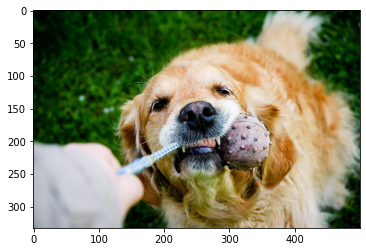

Greedy: startseq country lays lays lays lays lays touches beyond beyond beyond evil evil sand sand containing containing


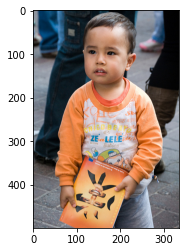

Greedy: startseq poses large cords photographer photographer country beads overlook overlook tricycles tricycles overlook tinkerbell amidst amidst amidst


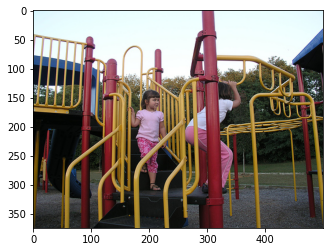

Greedy: startseq tackling tackling tackling tackling tackling tackling placed placed placed placed watering laid evil evil evil evil


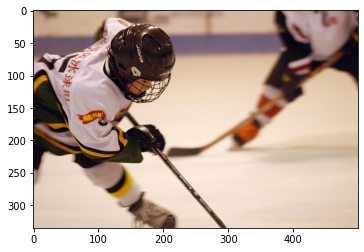

Greedy: startseq slip has necklaces bounces policeman policeman balloons balloons print print overlook shade shade shade shade amidst
====


In [ ]:
def test(i=5,j=20,k=50,q=850,show_pic=False):
    print('====')
    pic = list(test_features.keys())[i]
    photo = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread('Flicker8k_Dataset/'+pic+'.jpg')
        plt.imshow(x)
        plt.show()
    print("Greedy:",generate_desc(model, photo))
    #print("Actual:",test_descriptions[pic][0])
    #print("Actual:",test_descriptions[pic][1])
    
    pic = list(test_features.keys())[j]
    photo = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread('Flicker8k_Dataset/'+pic+'.jpg')
        plt.imshow(x)
        plt.show()
    print("Greedy:",generate_desc(model, photo))
    
    pic = list(test_features.keys())[k]
    photo = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread('Flicker8k_Dataset/'+pic+'.jpg')
        plt.imshow(x)
        plt.show()
    print("Greedy:",generate_desc(model, photo))
    pic = list(test_features.keys())[q]
    photo = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread('Flicker8k_Dataset/'+pic+'.jpg')
        plt.imshow(x)
        plt.show()
    print("Greedy:",generate_desc(model, photo))

    print('====')
    
    
test(show_pic=True)

In [ ]:
def progressBar(value, endvalue, bar_length=20,job='Job'):
    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))
    sys.stdout.write("\r{0} Completion: [{1}] {2}%".format(job,arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()

In [ ]:
def beam_search(model, photo, wordtoix, k_beams):
  start = [wordtoix['startseq']]
  start_word = [[start,0.0]]
  while len(start_word[0][0]) < max_length:
    temp = []
    for s in start_word:
      #sequence of most probable words 
      # based on the previous steps
      sequence  = pad_sequences([s[0]], maxlen=max_length).reshape((1,max_length)) 
      preds = model.predict([photo.reshape(1,2048), sequence])
      # sort predictions based on the probability  
      # then take the last K_beams items, words with the most probs
      word_preds = np.argsort(preds[0])[-k_beams:] 
      # Getting the top <K_beams>(n) predictions and creating a 
      # new list so as to put them via the model again
      for w in word_preds:
        next_cap, prob = s[0][:], s[1]
        next_cap.append(w)
        prob += preds[0][w]
        temp.append([next_cap, prob])
    start_word = temp
    # Sorting according to the probabilities
    start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
    # Getting the top words
    start_word = start_word[-k_beams:]

  start_word = start_word[-1][0]
  captions_ = [ixtoword[i] for i in start_word]
  final_caption = []
  for i in captions_:
    if i != 'endseq':
      final_caption.append(i)
    else:
      break

  final_caption = ' '.join(final_caption[1:])
  return final_caption

In [ ]:
def evaluate_model(model, description, photos, k_beams):
  actual, predicted = list(), list()
  # step over the whole set
  i=0
  for key, desc_list in description.items():
    i += 1
    progressBar(i, len(description), bar_length=20,job='Evaluating')
    if k_beams == 1:
      yhat = generate_desc(model, photos[key])
    else:
      yhat = beam_search(model, photos[key], wordtoix, k_beams=k_beams)
    # store actual and predicted
    references = [d.split() for d in desc_list]
    actual.append(references)
    predicted.append(yhat.split())
  b1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
  b2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
  b3 = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
  b4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
  print('\n')
  #score for 1-gram model
  print('BLEU-1: %f' % b1)
  #50% score calculated on 1-gram and other 50% using 2-gram
  print('BLEU-2: %f' % b2)
  #33% to each 1,2 and 3 gram
  print('BLEU-3: %f' % b3)
  # 1/4 score of each gram
  print('BLEU-4: %f' % b4)
  return [b1,b2,b3,b4]

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
epochs = 31
batch_size = 32
steps = len(train_descriptions)//batch_size
ep = 1
for i in range(ep,epochs):
  print('Epoch :',i,'\n')
  generator = data_generator(train_descriptions, train_features)
  #fit for one epoch
  h = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=my_callbacks)
  history['loss'].append(h.history['loss'])
  if i%3 == 0:
    model.save('new_model_' + str(i) + '.h5')
  
  if i%6 == 0:
    test()
    belus= evaluate_model(model, dev_descriptions, dev_features, k_beams=1)
    history['BLEU_val'].append((belus,i))
    print('\n','='*80)

dump(history,open('history.pkl','wb'))

Epoch : 1 



/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


187/187 [==============================] - 38s 202ms/step - loss: 5.4382
Epoch : 2 

187/187 [==============================] - 38s 201ms/step - loss: 4.8088
Epoch : 3 

187/187 [==============================] - 38s 201ms/step - loss: 4.4672
Epoch : 4 

187/187 [==============================] - 38s 205ms/step - loss: 4.2629
Epoch : 5 

187/187 [==============================] - 38s 205ms/step - loss: 4.0805
Epoch : 6 

187/187 [==============================] - 38s 201ms/step - loss: 3.9445
====
Greedy: startseq dog is running through the grass endseq
Greedy: startseq two people are playing in the water endseq
Greedy: startseq two people are playing in the water endseq
Greedy: startseq two people are playing in the water endseq
====
Evaluating Completion: [------------------->] 100%

BLEU-1: 0.568717
BLEU-2: 0.290187
BLEU-3: 0.184920
BLEU-4: 0.081470

Epoch : 7 

187/187 [==============================] - 37s 198ms/step - loss: 3.8164
Epoch : 8 

187/187 [============================

In [ ]:
model.save_weights('weights.h5')

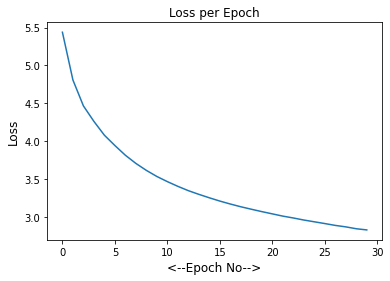

In [ ]:
y = []
y = [item for sublist in history['loss'] for item in sublist]
x = [i for i in range(len(history['loss']))]
plt.xlabel('<--Epoch No-->', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss per Epoch')
plt.plot(x,y)

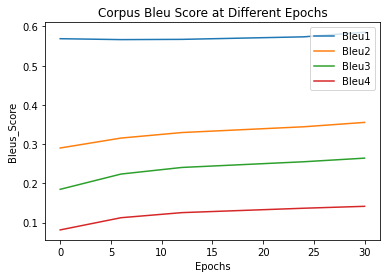

In [ ]:
y = []
y = [item for sublist in history['BLEU_val'] for item in sublist]
y = y[::2]
y1 = [item for sublist in y for item in sublist]
bleu_val1 = y1[::4]
bleu_val2 = y1[1::4]
bleu_val3 = y1[2::4]
bleu_val4 = y1[3::4]

x = [0,6,12,24,30]
plt.plot(x, bleu_val1, label = "Bleu1")
plt.plot(x, bleu_val2, label = "Bleu2")
plt.plot(x, bleu_val3, label = "Bleu3")
plt.plot(x, bleu_val4, label = "Bleu4")
plt.xlabel('Epochs')
plt.ylabel('Bleus_Score')
plt.title('Corpus Bleu Score at Different Epochs')
plt.legend()
plt.show()

In [ ]:
model = load_model('new_model_30.h5',custom_objects={'masked_loss_function':                
masked_loss_function})

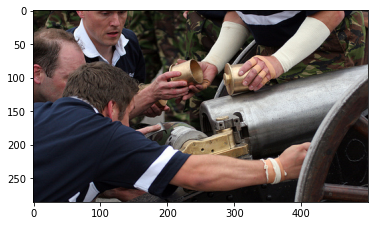

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Greedy: startseq three people are standing in front of an audience endseq
Beam K= 3: three people are standing in front of an audience


In [ ]:
pic = list(test_features.keys())[8]
feature = test_features[pic].reshape((1,2048))
x=plt.imread('Flicker8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, feature))
print("Beam K= 3:",beam_search(model, test_features[pic], wordtoix, k_beams = 3))